In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, \
    RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import uniform

In [2]:
df = pd.read_pickle('./all_data.pkl')

In [3]:
NUM_LABEL_COLS = 13
NUM_COMPONENTS = 26
RANDOM_SEED = 0

In [4]:
df_filtered = df
df_filtered.shape

(9080, 10790)

In [5]:
# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['trmp'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']
df_filtered = df_filtered[df_filtered['ext'] == '0']
df_filtered = df_filtered[df_filtered['excl'] == '0']
print('df filt shape: ', df_filtered.shape)

# we are keeping sop, alt, tenr, tora, bari, clrt, other = 7
                                                                        # off by one?
num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS                      # - 1 
print('num_x_cols:', num_x_cols)

data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ These are the features

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

# Create target column
combined = df_filtered[['sop']].to_numpy() + \
    df_filtered[['alto']].to_numpy() + \
    df_filtered[['tenr']].to_numpy() + \
    df_filtered[['tora']].to_numpy() + \
    df_filtered[['bari']].to_numpy()
    
combined = combined.astype('int')
combined[combined > 0] = 1
df_filtered['sax'] = combined

target = df_filtered[['sax']].to_numpy().ravel()  # << This is the label

print(data.shape)
print(target.shape)

df filt shape:  (7657, 10790)
num_x_cols: 10777
(7657, 10776)
(7657,)


In [6]:
y_true = np.where(target == 1)

y_true[0].shape

(4495,)

In [7]:
target[1] == 1

True

In [8]:
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(data)
PCA(n_components=29)

PCA(n_components=29)

In [9]:
d = pca.transform(data)

In [10]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target, test_size=0.20, random_state=0)

# Default SVM

In [15]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.8531331592689295


In [16]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,481,133
1,92,826


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       614
           1       0.86      0.90      0.88       918

    accuracy                           0.85      1532
   macro avg       0.85      0.84      0.85      1532
weighted avg       0.85      0.85      0.85      1532



# Random Search → C = 3.733

In [12]:
model_params = {
    'C': uniform(0.1, 10.0)
}

# RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, 
#                    scoring=None, n_jobs=None, iid='deprecated', 
#                    refit=True, cv=None, verbose=0, 
#                    pre_dispatch='2*n_jobs', random_state=None, 
#                    error_score=nan, return_train_score=False)
svm_model = SVC()
clf = RandomizedSearchCV(svm_model, model_params, n_iter=10, 
                         cv=5)
model = clf.fit(x_train, y_train)
params = model.best_estimator_.get_params()

In [13]:
 params

{'C': 3.733044855437362,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [14]:
clf = SVC(C=params['C'])
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.8616187989556136


In [15]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,500,114
1,98,820


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       614
           1       0.88      0.89      0.89       918

    accuracy                           0.86      1532
   macro avg       0.86      0.85      0.86      1532
weighted avg       0.86      0.86      0.86      1532



# Ensemble with bagging classifier → max_features = 23 

In [17]:
# Parameters
p = {'max_features': [NUM_COMPONENTS - 2, NUM_COMPONENTS - 3, 
                      NUM_COMPONENTS - 4, NUM_COMPONENTS - 5,
                      NUM_COMPONENTS - 6, NUM_COMPONENTS - 7]}

base_estimator = SVC(C=params['C'])
estimator = BaggingClassifier(base_estimator=base_estimator, n_estimators=100)
# Question: Should we include C here, or ... ? There's no reason it should differ
# for different values of n_estimators, but what about max_features? Might different
# values for C be best for different max_features? Maybe. Dunno. Maybe we should
# search for optimal C *after* we've found the best value for max_features?

# GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, 
#              iid='deprecated', refit=True, cv=None, verbose=0, 
#              pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
clf = GridSearchCV(estimator, p, n_jobs=-1)
search = clf.fit(x_train, y_train)
search.best_params_

# gives max_feat = 21 as best

{'max_features': 23}

In [53]:
clf = BaggingClassifier(base_estimator=SVC(C=params['C'],
                                           probability=True),
                        n_estimators=500, 
                        max_features=23,
                        random_state=RANDOM_SEED,
                        n_jobs=-1)
model = clf.fit(x_train, y_train)

In [54]:
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.8661879895561357


In [55]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,496,118
1,87,831


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       614
           1       0.88      0.91      0.89       918

    accuracy                           0.87      1532
   macro avg       0.86      0.86      0.86      1532
weighted avg       0.87      0.87      0.87      1532



In [57]:
fn = './models/sax_xbrass_svm_bagging_C_3733_MF_23.pkl'
with open(fn, 'wb') as fh:
    pickle.dump(clf, fh)

# Evaluation of Tuned SVM

In [58]:
probas_pred = clf.predict_proba(x_test)

In [59]:
y_true = [1 if x == 1 else 0 for x in y_test]

In [60]:
y_pred_pos = probas_pred[:, [1]]
precision, recall, threshold = precision_recall_curve(y_true, y_pred_pos)

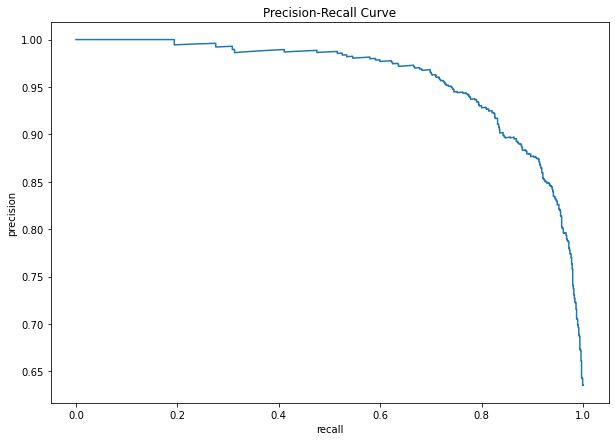

In [69]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")

plt.savefig('PRC.png')

In [62]:
fpr, tpr, threshold = roc_curve(y_true, y_pred_pos)
auc = roc_auc_score(y_true, y_pred_pos)

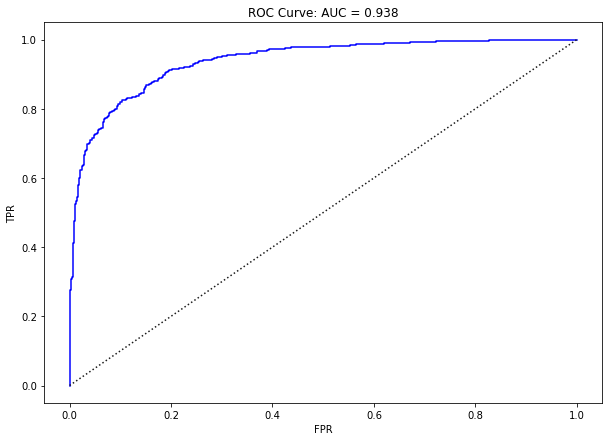

In [68]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 

plt.savefig('ROC.png')

<Figure size 432x288 with 0 Axes>